In [1]:
## %%# General
import warnings
warnings.filterwarnings ( "ignore" )
import os
from datetime import datetime,timedelta  #time,
import matplotlib.pyplot as plt

# Scientific and data
import numpy as np
from tqdm import tqdm
import pandas as pd
import  xarray as xr
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import griddata

eps = np.finfo(np.float).eps

# pytorch
import torch.utils.data

torch.manual_seed(8318)


# Local modules
import  learning_lidar.utils.global_settings as gs
import learning_lidar.preprocessing.preprocessing as prep
import learning_lidar.utils.xr_utils as xr_utils
from learning_lidar.utils.misc_lidar import calc_extiction_klett
# %%

def make_interpolated_image(nsamples,im):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """
    nx, ny = im.shape[1], im.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X),method = 'nearest',fill_value = 0)
    return int_im

def angstrom(tau_1,tau_2, lambda_1,lambda_2):
	"""
	calculates angstrom exponent
	:param tau_1: AOD Aerosol optical depth at wavelength lambda_1
	:param tau_2: AOD Aerosol optical depth at wavelength lambda_2
	:param lambda_1: wavelength lambda_1 , lambda_1<lambda_2 (e.g. 355 nm)
	:param lambda_2: wavelength lambda_2 , lambda_1<lambda_2 (e.g. 532 nm)
	:return: angstrom exponent A_1,2
	"""
	return -np.log(tau_1/tau_2)/np.log(lambda_1/lambda_2)

## Generate daily dataset of beta aerosol - based on measurments and calibration knoledge from TROPOS:
from the molecular dataset load: (saved as: 2017_09_18_Haifa_molecular.nc)
1. $Pr^2$  (generated from LC*attbsc)
2. $\sigma_m$ (generated from radiosondes)
3. $\beta_m$
3. $r_{mid}$ - from the ds_day (the dataset generated above)

## Load extended databsae

In [2]:
# %%
station_name = 'haifa'
station = gs.Station ( stations_csv_path = 'stations.csv' , station_name = station_name )
start_date = datetime ( 2017 , 9 , 1 )
end_date = datetime ( 2017 , 10 , 31 )
ds_path_extended = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.nc"
ds_extended = prep.load_dataset ( ds_path_extended)
wavelengths = [355,532,1064]

# %%

## Choose a day

In [56]:
# %%
df_times = ds_extended.Time.to_pandas()
time_00 = datetime.today().time().min
days = [datetime.combine(day,time_00) for day in sorted(df_times.groupby(df_times.dt.date).groups.keys())]
day_number = 20
day = days[day_number]
day_str = day.strftime('%Y-%m-%d')
end_day= day + timedelta(hours = 24) - timedelta(seconds = 30)
slice_day = slice(day,end_day)
ds_day = ds_extended.sel(Time = slice_day).copy(deep = True)
# %%

### Resample the ds_day such that each of variables has a values every 30S

In [57]:
# %%
time_indx = pd.date_range(start = day, end = end_day,freq = '30S')
ds_day = ds_day.resample(Time='30S').interpolate('nearest')
ds_day = ds_day.reindex({"Time" : time_indx}, method="nearest",fill_value =  0)
ds_day.attrs[ 'day_date' ] = day.date()
ds_day.attrs['long_name'] = 'Daily calibration parameters'

# %%
#display(ds_day)

## 1. Calibration parameter for the chosen day: $LC$ and $r_{mid}$
- Plotting the Lidar constant and reference heights of the day

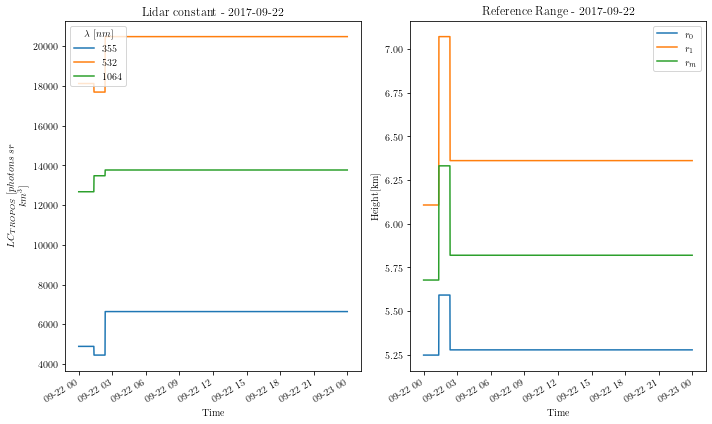

In [58]:
# %%
ds_smooth = ds_day.apply(func = gaussian_filter1d,sigma=30,keep_attrs =True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
ax = axes.ravel()
ds_day.LC.plot(x='Time',hue='Wavelength',ax=ax[0])
#ds_smooth.LC.plot(x='Time',hue='Wavelength',ax=ax[0],linestyle='--')#,colors =['b','g','r'])
"""for l,c in zip(ax[0].lines,['b','g','r','b','g','r']):
	l.set_color(c)

ax[0].legend(ax[0].lines[0:3],ds_day.Wavelength.values)
"""
ax[0].set_title(f'Lidar constant - {day_str}')
for r in ['r0','r1','rm']:
	#ds_smooth[r].sel(Wavelength=355).plot(ax=ax[1],linestyle='--')
	ds_day[r].sel(Wavelength=355).plot(label=ds_day[r].long_name,ax=ax[1])
ax[1].set_title(f'Reference Range - {day_str}')
ax[1].set_ylabel('Height[km]')
plt.legend()
plt.tight_layout()
plt.show()
# %%

## Load molecular and lidar profiles

In [59]:
# %%
month_folder_mol = prep.get_month_folder_name ( station.molecular_dataset , day )
month_folder_aer = prep.get_month_folder_name ( station.lidar_dataset , day )
mol_file_name = xr_utils.get_prep_dataset_file_name ( station , day , data_source = 'molecular',lambda_nm = 'all', file_type = 'all' )
aer_file_name = xr_utils.get_prep_dataset_file_name ( station , day , data_source = 'lidar',lambda_nm = 'all', file_type = 'all' )
mol_ds = prep.load_dataset(os.path.join(month_folder_mol,mol_file_name))
aer_ds = prep.load_dataset(os.path.join(month_folder_aer,aer_file_name))
aer_ds.range_corr.attrs['long_name'] = r'$LC \beta \cdot \exp(-2\tau)$'
mol_ds['Height']= aer_ds.Height # This is to make sure that Height indexes are the same! otherwise math operations of xarray will not work
# %%

## 2. Show $pr^2$, $\sigma_m$, $\beta_m$

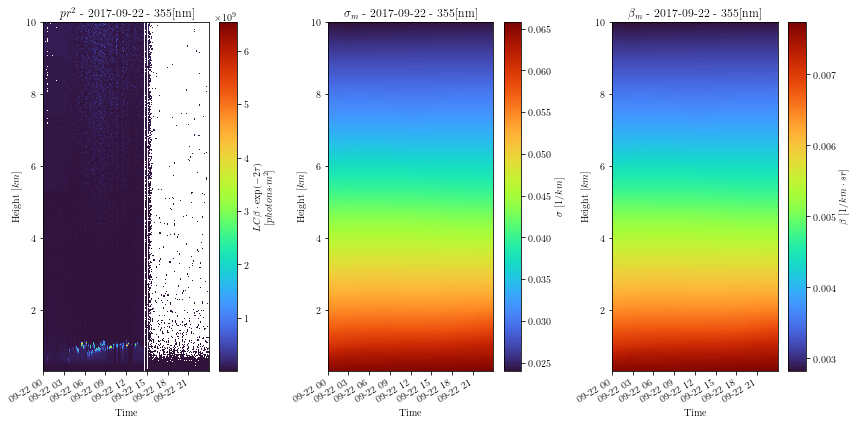

In [60]:
# %%
wavelength = 355
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
ax = axes.ravel()
aer_ds.range_corr.where(aer_ds.range_corr>0).sel(Height=slice(0,10.0),Wavelength=532).plot(ax = ax[0],cmap='turbo')
mol_ds.sigma.sel(Height=slice(0,10.0), Wavelength=wavelength).plot(ax = ax[1],cmap='turbo')
mol_ds.beta.sel(Height=slice(0,10.0),Wavelength=wavelength).plot(ax = ax[2],cmap='turbo')
for ax,stitle in zip(axes.ravel(),[r'$pr^2$', r'$\sigma_m$', r'$\beta_m$']):
	ax.set_title(f'{stitle} - {day_str} - {wavelength}[nm]')
plt.tight_layout()
plt.show()
# %%

### To synthesize daily $\sigma$ and $\beta$ profiles, for each wavelength $\lambda$ and day $d$:
## 1. Set the interesting layer of aerosol to be as $[0.0,r_{max}]$, where 0.0 - is relative to lidar height (not sea level!), $r_{max} = max(r_1), \forall t\in d$
> Note: extend the slicing such that it take into account a map (as in segmentation)

In [61]:
# %%
r_min = ds_day.r0.min().item()
r_max = ds_day.r1.max().item()
r_mid = 0.5*(r_max+r_min)
layer_0 = slice(0.0,r_min + 0.25*(r_mid-r_min))# slice(0.0,r_min*1.3)
layer_1 = slice(0.75*r_min,r_mid) #slice(r_min*.70,r_max)
layer_2 = slice(r_mid,r_max)
merged_layer = slice(0.0,r_max)
print(f'The interesting Height layer:{merged_layer}[km]')
# %%

The interesting Height layer:slice(0.0, 7.070421875, None)[km]


## 2. Slice $pr^2$, the signal measured, up to $r_{max}$.

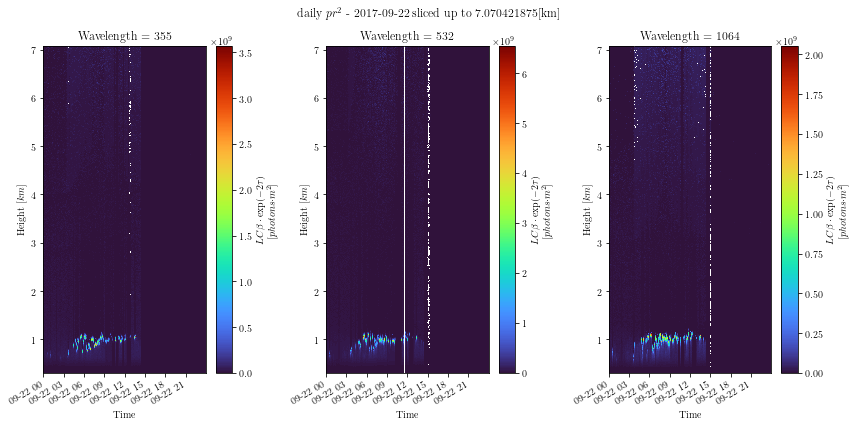

In [62]:
# %%
pr2_merged_layer = aer_ds.range_corr.sel(Height =merged_layer).copy(deep=True)# slice(0.0,9.6480751953125)).copy(deep=True)
pr2_merged_layer.name = r'$pr^2$'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	pr2_merged_layer.where(pr2_merged_layer>=0).sel(Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily $pr^2$ - {day_str} sliced up to {r_max}[km]')
plt.tight_layout()
plt.show()
# %%

## 3. Fill nan values using cubic interpolation

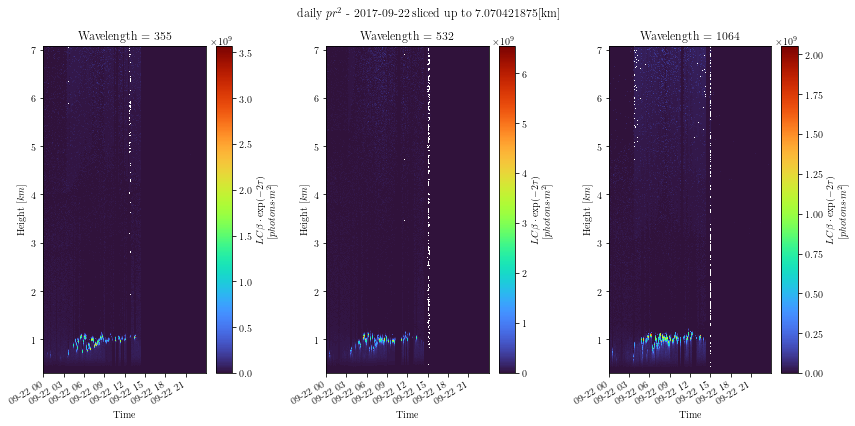

In [63]:
# %%
pr2_merged_layer = pr2_merged_layer.interpolate_na(dim = 'Time',keep_attrs = True,method = 'nearest')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	pr2_merged_layer.where(pr2_merged_layer>=0).sel(Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily $pr^2$ - {day_str} sliced up to {r_max}[km]')
plt.tight_layout()
plt.show()
# %%

In [64]:
# %% Slice the molecular signal
sigma_merged_layer = mol_ds.sigma.sel(Height =merged_layer).copy(deep=True)
# %%

## 4. Create a mask with zeros on bins with negative values, and time slots that were not analysed (such clouds or calibration periods)
> TBD

## 5. Masking non-relevant pixels according to reference height

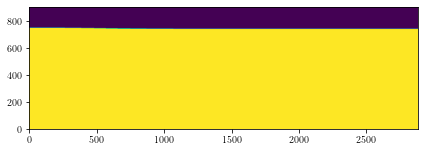

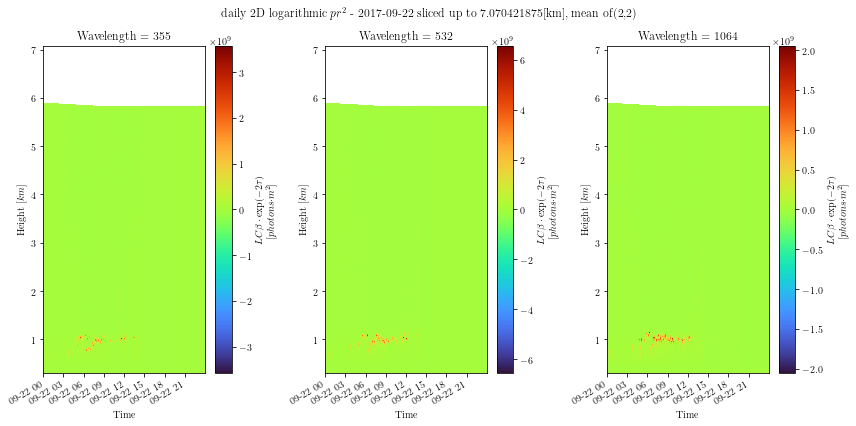

In [65]:
# %%
cut_r0 = ds_day.apply(func = gaussian_filter1d,sigma=360,keep_attrs =True).rm
mask_rm = pr2_merged_layer.Height.where(pr2_merged_layer.Height<= cut_r0).sel(Wavelength=532).values #.sel(Wavelength =1064)
mask_rm[~np.isnan(mask_rm)] = 1.0
mask_rm[np.isnan(mask_rm)] = 0.0
plt.figure()
plt.imshow(mask_rm)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
mask_rm = mask_rm.astype(bool)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	pr2_merged_layer.where(mask_rm==True).sel(Wavelength = wavelength).plot(cmap='turbo',ax =ax)
plt.suptitle(fr'daily 2D logarithmic $pr^2$ - {day_str} sliced up to {r_max}[km], mean of(2,2)')
plt.tight_layout()
plt.show()

# %%

## 6. Klett inversion :
- Calculating logarithmic range corrected power
- $\forall t\in d$ calculate $\sigma$ using KLETT inversion method (using $Pr^2$, $\sigma _m$, $r _{mid}$)
- This is relevant mainly to $r<=r_{max}$. Since this is a generation process.
> Make sure to do the calculation only on "reading" time slots

#### 6.1 Calculate range corrected signal

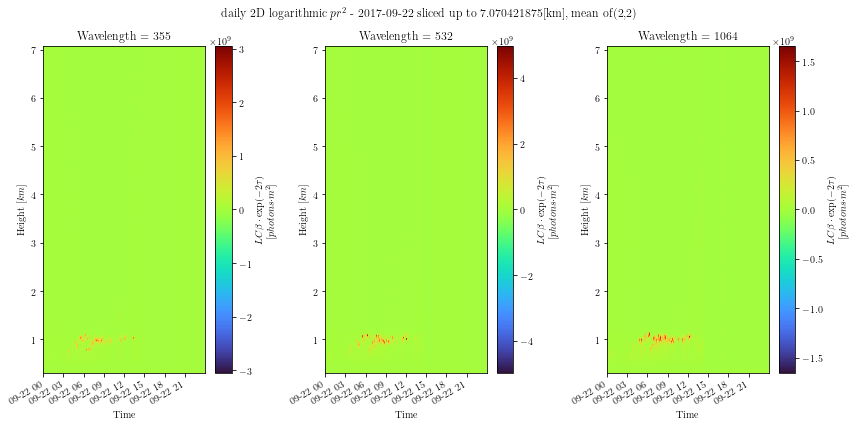

In [66]:
# %%
pr2_merged_layer_mean = pr2_merged_layer.rolling(Time =3,Height=3, min_periods=1, center = True,keep_attrs = True).mean()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	pr2_merged_layer_mean.sel(Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily 2D logarithmic $pr^2$ - {day_str} sliced up to {r_max}[km], mean of(2,2)')
plt.tight_layout()
plt.show()

#### 6.2 Calculate logarithmic range corrected signal (for Klett) -  $\ln(p \cdot  r^2)$

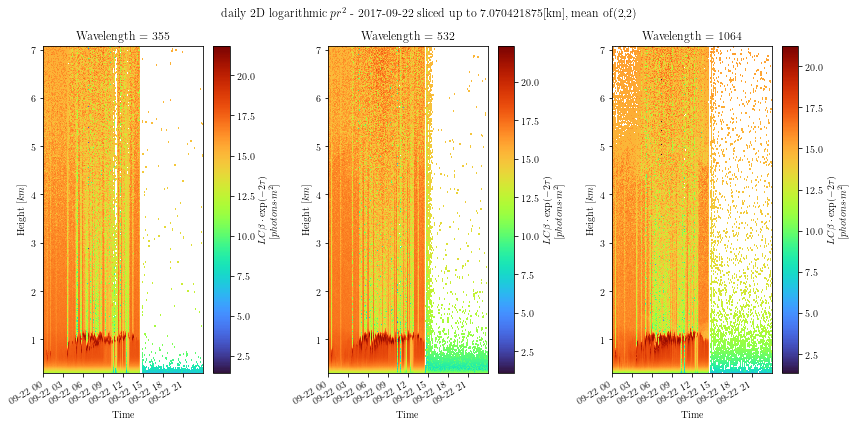

In [67]:
# %%
S_mean = xr.apply_ufunc(lambda x: np.log(x),pr2_merged_layer_mean,keep_attrs = True )
S_mean.name= r'$\ln(pr^2)$'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	S_mean.sel(Height=slice(0,10.0),Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily 2D logarithmic $pr^2$ - {day_str} sliced up to {r_max}[km], mean of(2,2)')
plt.tight_layout()
plt.show()
# %%

#### 6.3 Mask negative values - logarithmic range corrected signal (errornous values)

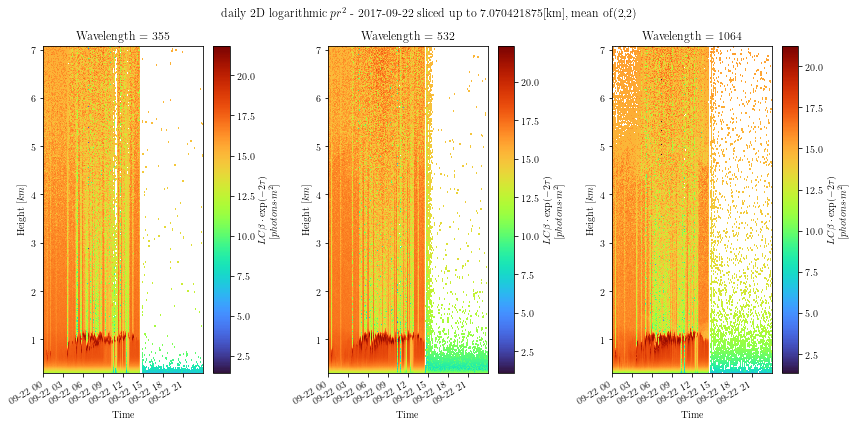

In [68]:
# %%
mask_s = S_mean.where(S_mean>=0.0).values
mask_s[~np.isnan(mask_s)] = 1.0
mask_s[np.isnan(mask_s)] = 0.0
mask_s = mask_s.astype(bool)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for ind,(wavelength,ax) in enumerate(zip(wavelengths,axes.ravel())):
	S_mean.loc[dict(Wavelength=wavelength)].values[~mask_s[ind]]=eps
	S_mean.where(S_mean>eps).sel(Height=slice(0,10.0),Wavelength = wavelength).plot(cmap='turbo',ax=ax)
plt.suptitle(fr'daily 2D logarithmic $pr^2$ - {day_str} sliced up to {r_max}[km], mean of(2,2)')
plt.tight_layout()
plt.show()
# %%

#### 6.4 Set parametets for Klett calculation

In [69]:
alt_km = station.altitude*1e-3
heights = pr2_merged_layer.Height.values - alt_km
dr = heights[1]-heights[0]

#### 6.5 Test klett retrival on a single time

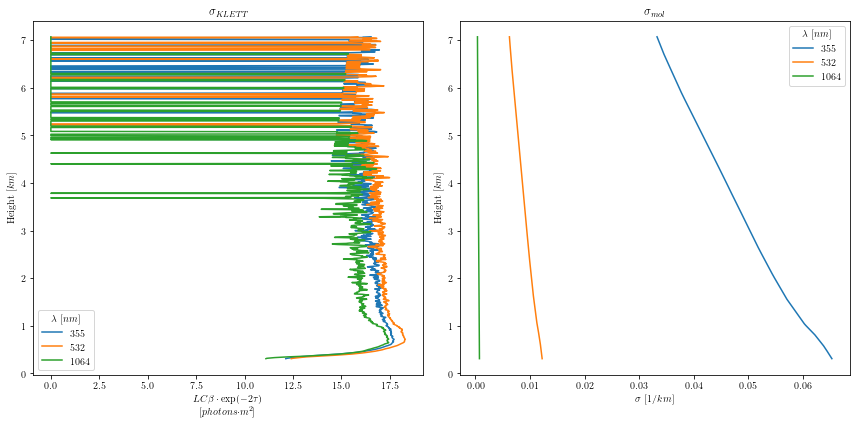

In [70]:
wavelength = 532
bin_t = 100
t  = ds_day.Time.values[bin_t]
ind_m =int(ds_day.bin_r0.sel( Time =t,Wavelength=wavelength).values.item())
sigma_t = sigma_merged_layer.sel(Time= t)
S_t = S_mean.sel(Time= t)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax = axes.ravel()
S_t.plot(y='Height',ax=ax[0],hue='Wavelength')
ax[0].set_title(r'$\sigma_{KLETT}$')
sigma_t.plot(y='Height',ax=ax[1],hue='Wavelength')
ax[1].set_title(r'$\sigma_{mol}$')
plt.tight_layout()
plt.show()

# %%

#slice_t = slice(day + timedelta(hours = 21),day + timedelta(hours = 21.5))
#sigma_merged_layer.sel(Time= slice_t,Wavelength=532).mean(dim='Time').plot(y='Height')
#plt.show()

#S_mean.sel(Wavelength = wavelength,Time= ds_day.Time.values[bin_t]).plot(label = fr'{t}')
#S_mean.sel(Time=slice(ds_day.Time.values[bin_t],ds_day.Time.values[bin_t+5])).mean(dim='Time').sel(Wavelength = wavelength).plot(label='mean 30 minutes profile')
#plt.legend()
#plt.show()
# %%

#### 6.4 $\sigma_{Klett}$ retrieval vs molecular profile for a specific time slot

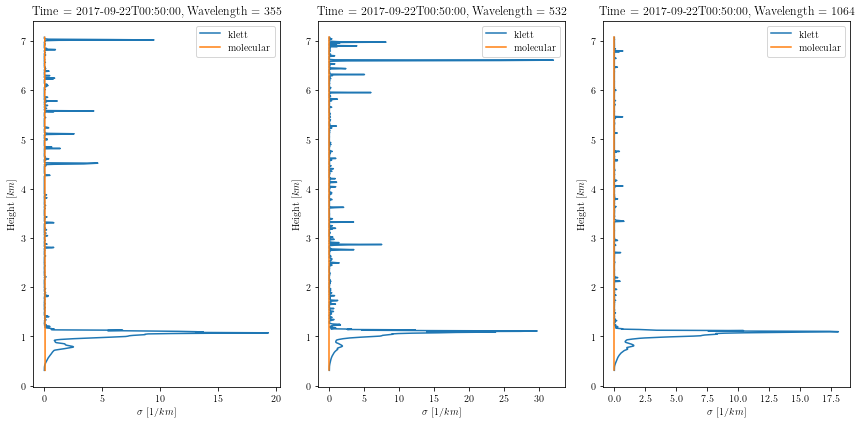

In [71]:
# %%
bin_t = 700
slicet = slice(ds_day.Time.values[bin_t],ds_day.Time.values[bin_t+15])
S_t = S_mean.sel(Time=slicet).mean(dim='Time')
ind_m =int(ds_day.bin_rm.sel( Time =slicet,Wavelength=wavelength).astype(float).mean().item())
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	ind_m =int(ds_day.bin_rm.sel( Time =t,Wavelength=wavelength).values.item())
	sigma_klett = xr.apply_ufunc(lambda x,y: calc_extiction_klett(x,heights,y,ind_m),
	                             S_t.sel(Wavelength = wavelength),sigma_t.sel(Wavelength = wavelength),
	                             keep_attrs = True)
	ax.set_title(wavelength)
	sigma_klett.name = r'$\sigma_{klett}$'
	sigma_klett.plot(y='Height',ax= ax,label='klett')
	sigma_t.sel(Wavelength = wavelength).plot(y='Height',ax=ax,label='molecular')
	ax.legend()
plt.tight_layout()
plt.show()
# %%

#### 6.5 Solving Klett throughout day
- Plotting the daily estimated $\sigma(r,t)$ ,$s.t.\, \sigma(r,t)\geq 0,\; r\leq r_{mid}\, t\in Times_{day}$

100%|██████████| 2880/2880 [00:10<00:00, 266.07it/s]


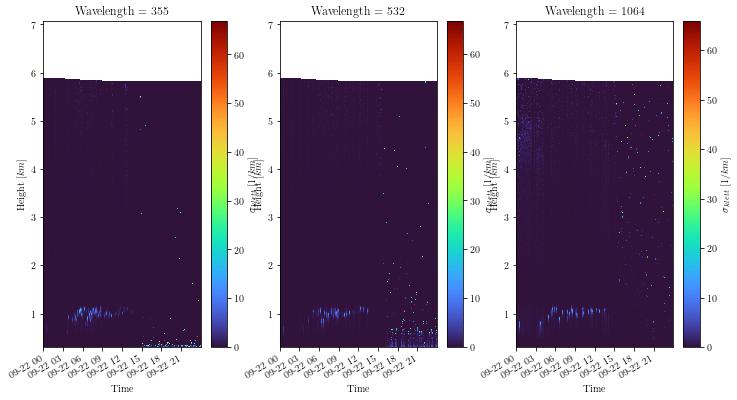

In [72]:
# %%
sigma_klett_c =[]
for wavelength in wavelengths:
	sigma_klett_t =[]
	for t in tqdm(ds_day.Time):
	#t  = ds_day.Time.values[bin_t]
		ind_m =int(ds_day.bin_r0.sel( Time =t,Wavelength=wavelength).values.item())
		sigma_t = sigma_merged_layer.sel(Time= t)
		#S_t = pr2_merged_layer_mean.sel(Time=t)
		S_t = S_mean.sel(Time= t)
		sigma_klett = xr.apply_ufunc(lambda x,y: calc_extiction_klett(x,heights,y,ind_m),
	                             S_t.sel(Wavelength = wavelength),
	                                 sigma_t.sel(Wavelength = wavelength),
		                             keep_attrs = True)
		sigma_klett.name = r'$\sigma_{klett}$'
		sigma_klett_t.append(sigma_klett)

	sigma_klett_c.append(xr.concat(sigma_klett_t,dim = 'Time'))
sigma_klett_d = xr.concat(sigma_klett_c,dim = 'Wavelength')#.plot(x='Time',cmap='turbo')
sigma_klett_d.attrs['long_name'] = r'$\sigma_{klett}$'
sigma_klett_d.attrs['units'] = r'$1/km$'
sigma_klett_d.attrs['info'] = 'Extinction daily profile generated using KLETT'

klett_mean = sigma_klett_d.copy(deep=True)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip(wavelengths,axes.ravel()):
	klett_mean.where(mask_rm.T == True).where(klett_mean>0.0).sel(Wavelength= wavelength).plot(ax=ax,x='Time',cmap='turbo')
plt.show()
# %%

## 6.6. calculate the aerosol extinction:
## $\sigma_a(r) = \sigma(r) - \sigma _m(r)$

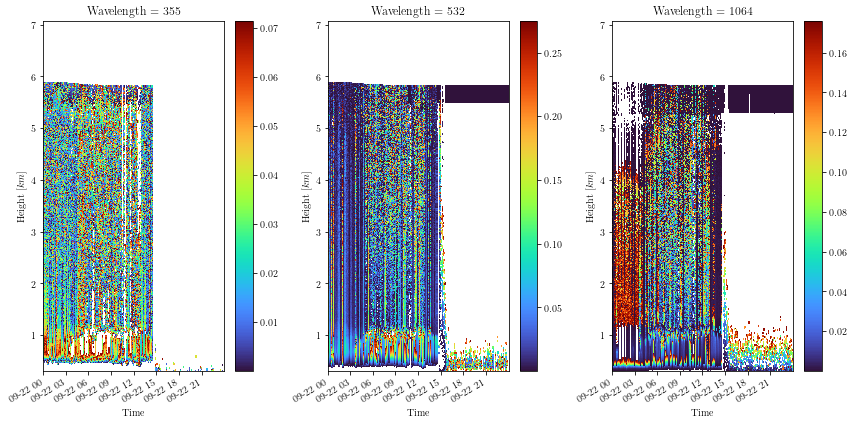

In [73]:
# %%
sigma_aer = klett_mean-sigma_merged_layer
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
max_val = 55*np.array([0.0013,0.005,0.0032])
for wavelength,ax,max_v in zip(wavelengths,axes.ravel(),max_val):
	sigma_aer.where(mask_rm.T == True).where(sigma_aer>0.0).where(sigma_aer<=max_v).sel(Wavelength= wavelength).plot(ax=ax,x='Time',cmap='turbo')
plt.tight_layout()
plt.show()
# %%

## 6.7 calculate the aerosol backscatter:
- Assume the lidar ratio to be a constant $LR=50[sr]$, and use it to to calculate $\beta_a = \frac{\sigma_a}{LR}$

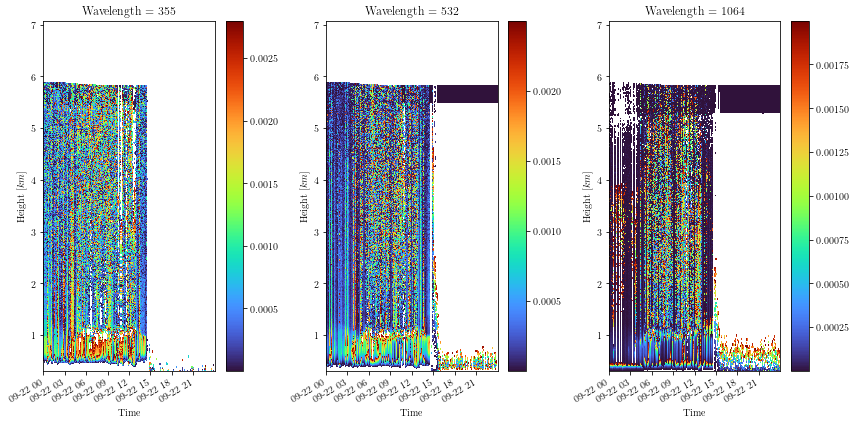

In [74]:
# %%
LR = 50 # [sr] = Lidar Ratio
beta_aer = sigma_aer.copy(deep=True)
beta_aer/=LR
max_val = np.array([0.0028,0.0025,0.0020])
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax,max_v in zip(wavelengths,axes.ravel(),max_val):
	beta_aer.where(mask_rm.T == True).where(beta_aer>=0).where(beta_aer<=max_v).sel(Wavelength= wavelength).plot(ax=ax,x='Time',cmap='turbo')
plt.tight_layout()
plt.show()
# %%

## Plan to "use" the above retrivals
### This is not going to any good direction - moving on to density generation
7. "Manipulating" aerosol values:
	- Start from $\lambda=1064[nm]$ since the signal is less affected by the molecular scattering. Then normalize it, and multiply with maximum values of the TROPOS retreival for each wavelength.
	- $\forall r\in [r_{min}, r_{max}]$: reduce dramatically the values of $\sigma_a(r)$ and $\beta_a(r)$
	- $\forall r>r_{max}$: zero the values of $\sigma_a(r)$ and $\beta_a(r)$
	- "Fill in" the missing values of the mask using 2D interpolation & gaussian smoothing
	> Note: "inpainting" can improve the outcome.
8. Add the molecular profile as follows: $\sigma = \sigma_a + \sigma_m$, $\beta = \beta_a + \beta_m$ .

9. create "heatmap" of  reference range, starting from where tha aerosols are 10% of the total extinction/backscatter coefficient.
> TBD
10. Calculate a new Lidar signal $p$, by using the smoothed $LC$ values during the day (see ds_smooth above)
11. Create a mean background noise $<p_{bg}>$, using previous calculation
> Note: Later change the values according to sun rise and sun set times , and change also the maximum height of the gaussian curve
12. Calculate a new signal $p_{new} \sim Poiss (p_{std}) $,  such that $p_{std} = \sqrt p + <p_{bg}>$

## 7. Calculate Aearosol Optical Depth (AOD)
## $\tau_{aer,\lambda} = \int \sigma_{aer,\lambda} (r) dr\;\; \forall \, r \leq r_{ref} $
> TODO: need to validate values with AOD calculations from AERONET,

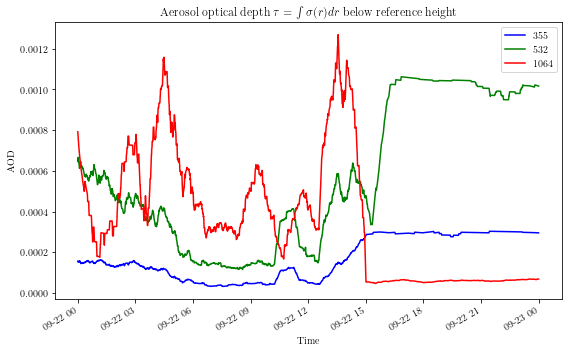

In [75]:
# %%
ADO_ds = sigma_aer.where(sigma_aer>0.0).where(sigma_aer<=max_v)*dr
ADO_ds = ADO_ds.sum(dim="Height",skipna= True,keep_attrs=True)
ADO_ds = ADO_ds.where(ADO_ds>=0,drop=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax = axes
for wavelength,max_v,c in zip(wavelengths,max_val,['b','g','r']):
	ADO_ds.sel(Wavelength= wavelength).rolling(Time =121,min_periods=1, center = True,keep_attrs = True).mean().plot(x='Time',ax =ax,label =wavelength,color=c)
	ax.set_ylabel(r'AOD')
	ax.set_title(r'Aerosol optical depth $\tau = \int \sigma (r) dr $ below reference height')
	plt.legend()
plt.tight_layout()
plt.show()
# %%

## 8. Calculate Angstrom exponent
## $A = -\frac {\ln(\tau_1/\tau_2)}{\ln(\lambda_1/\lambda_2)},\; \lambda_1\leq\lambda_2$

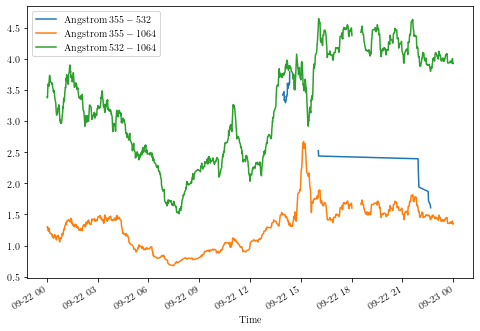

In [76]:
# %%
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax = axes
couples = [(355,532),(355,1064),(532,1064)]
angstrom_daily = []
for lambda_1,lambda_2 in couples:
	angstrom_couple = xr.apply_ufunc(lambda x,y:angstrom(ADO_ds.sel(Wavelength=x),ADO_ds.sel(Wavelength=y),x,y),lambda_1,lambda_2,keep_attrs = True)#xr.apply_ufunc(lambda x,y:angstrom(ADO_ds.sel(Wavelength=x),ADO_ds.sel(Wavelength=y),x,y),lambda_1,lambda_2,keep_attrs = True)
	angstrom_couple = angstrom_couple.where(angstrom_couple>=0,drop=True)
	angstrom_couple.rolling(Time =61,min_periods=1, center = True,keep_attrs = True).mean().plot(x='Time',label =fr"$\rm Angstrom\, {lambda_1} - {lambda_2}$",ax = ax)
plt.legend()
plt.show()
# %%